In [1]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Read the CSV file
df = pd.read_csv('ANON36_death_EKG_output.csv')

# change variable names
df = df.rename(columns={
    'Risk- Hypertension' : 'Hypertension',
    'Risk- Hypercholesteremia' : 'Hypercholesteremia', 
    'Risk- Hypertriglyceridemia' : 'Hypertriglyceridemia',
    'Risk- High HDL' : 'High HDL', 
    'Risk- Low HDL' : 'Low HDL', 
    'Risk- Diabetes' : 'Diabetes', 
    'Risk- Family Hx' : 'Family Hx',
    'Risk- Smoke' : 'Smoke', 
    'ASCVD PCE Risk Score' :'ASCVD PCE Risk',
    'PREVENT Score - ASCVD 10-year risk' : 'PREVENT ASCVD Risk', 
    'CVD PREVENT 10yr' : 'PREVENT CVD Risk',
    'HF PREVENT 10-year' : 'PREVENT HF Risk', 
    'Total A' : 'Total CAC Score', 
    'LM A' : 'CAC Score (Left Main)', 
    'LAD A' : 'CAC Score (LAD)', 
    'Cx' : 'CAC Score (LCx)', 
    'RCA' : 'CAC Score (RCA)',
    'Num Lesions' : 'Number of Total Lesions', 
    'Lesion Vol Sum' : 'Total Volume Score', 
    'Lesion Max D' : 'Peak CAC Density', 
    'Lesion Ave D' : 'Mean CAC Density', 
    'Male' : 'Gender',
    'Race_encoded' : 'Race',
})


In [3]:
# Select the columns
X = df.drop(['CONFIRM ID', 'result'], axis=1)
y = df['result']

# Make some columns categorical
categorical_cols = [X.columns[i] for i in [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,45]]
for col in categorical_cols:
    X[col] = X[col].astype('category')

print(X.dtypes)
# Initialize StratifiedKFold for 10-fold cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=94)

# Create the XGBClassifier
clf = xgb.XGBClassifier(tree_method="hist", enable_categorical=True, random_state=42)

# Placeholder for the stacked probabilities
stacked_probabilities = np.zeros(y.shape)

# List to hold AUC scores for each fold
auc_scores = []

Age                         float64
BMI                         float64
Beta Blockers              category
Antianginal Agents         category
Antihyperlipidemic         category
Calcium Blockers           category
Antihypertensive           category
Antidiabetic               category
Antiarrhythmic             category
Hypertension               category
Hypercholesteremia         category
Hypertriglyceridemia       category
High HDL                   category
Low HDL                    category
Diabetes                   category
Family Hx                  category
Smoke                      category
ASCVD PCE Risk              float64
PREVENT ASCVD Risk          float64
PREVENT CVD Risk            float64
PREVENT HF Risk             float64
VentricularRate             float64
AtrialRate                  float64
QRSDuration                 float64
QTInterval                  float64
QTCorrected                 float64
RAxis                       float64
TAxis                       

Final AUC-ROC: 0.7428243964498378


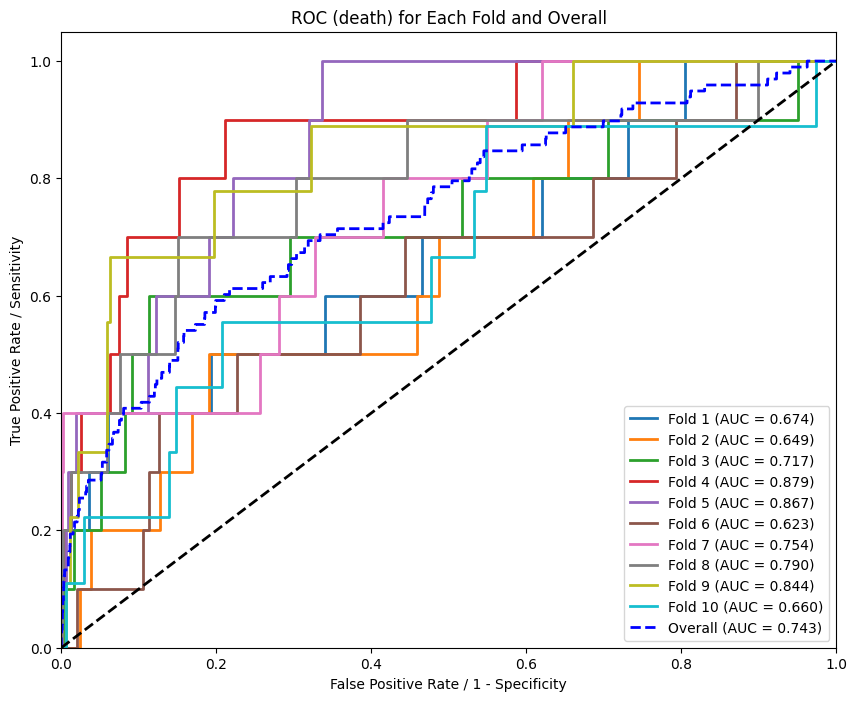

In [4]:
# Cross-validation loop
plt.figure(figsize=(10, 8))  # Set figure size for better visualization
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train the model
    clf.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
    
    # Predict probabilities
    y_pred_proba = clf.predict_proba(X_test)[:, 1]
    stacked_probabilities[test_index] = y_pred_proba
    
    # Calculate AUC for the current fold
    fold_auc = roc_auc_score(y_test, y_pred_proba)
    auc_scores.append(fold_auc)

    # Calculate ROC curve for the current fold
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    
    # Plot the ROC curve for the current fold
    plt.plot(fpr, tpr, lw=2, label=f'Fold {len(auc_scores)} (AUC = {fold_auc:.3f})')

# Final evaluation
final_auc = roc_auc_score(y, stacked_probabilities)
print(f"Final AUC-ROC: {final_auc}")

# Plot the overall ROC curve
fpr, tpr, _ = roc_curve(y, stacked_probabilities)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='blue', lw=2, linestyle='--', label=f'Overall (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')

# Finalize plot settings
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate / 1 - Specificity')
plt.ylabel('True Positive Rate / Sensitivity')
plt.title('ROC (death) for Each Fold and Overall')
plt.legend(loc="lower right")
plt.show()

Final AUC-ROC: 0.7428243964498378


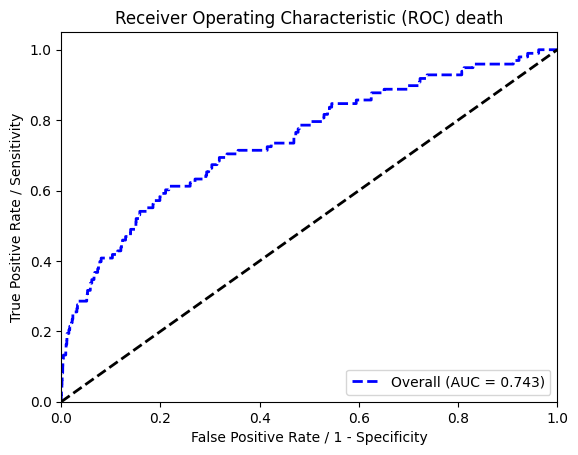

In [5]:
# Final evaluation
final_auc = roc_auc_score(y, stacked_probabilities)
print(f"Final AUC-ROC: {final_auc}")

# Plot the overall ROC curve
fpr, tpr, _ = roc_curve(y, stacked_probabilities)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='blue', lw=2, linestyle='--', label=f'Overall (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')

# Finalize plot settings
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate / 1 - Specificity')
plt.ylabel('True Positive Rate / Sensitivity')
plt.title('Receiver Operating Characteristic (ROC) death')
plt.legend(loc="lower right")
plt.show()